All libraries imported *here*

In [3]:
#Imports
import numpy as np
import pandas as pd
import re
import os
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, MaxPooling1D, Convolution1D, Dropout, Activation, GlobalMaxPool1D
from tensorflow.keras.optimizers import RMSprop
from keras.models import Model, Sequential
from tensorflow.keras import regularizers
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to /home/rajiv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rajiv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading the dataset



In [4]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
#Load the dataset
df = pd.read_csv(r'twitter_sentiment.csv', encoding = 'latin1')
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [6]:
df.rename(columns={"0": 'sentiment' ,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D": "tweet"}, inplace = True)

In [7]:
df = df[['sentiment','tweet']]

In [8]:
df

,sentiment,tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
1599994,4,Just woke up. Having no school is the best fee...
1599995,4,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...


In [9]:
df.info() #All non NULL values in both columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   tweet      1599999 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [10]:
df.sentiment.value_counts() #Sentiments need to be converted to 1 for positive, 0 for -ve

4    800000
0    799999
Name: sentiment, dtype: int64

In [11]:
df.iloc[0][1] #Data needs to be cleaned as it contains some html tags(<br /><br />), uppercase letters

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

In [12]:
def clean_data(text):
  #text = re.sub(r'', '', text) #Removes Html tag
  text = re.sub(r'[^\ a-zA-Z0-9]+', '', text)  #Removes non alphanumeric
  text = re.sub(r'^\s*|\s\s*', ' ', text).strip() #Removes extra whitespace, tabs
  stop_words = set(stopwords.words('english')) 
  lemmatizer = WordNetLemmatizer()
  text = text.lower().split() #Converts text to lowercase
  cleaned_text = list()
  for word in text:        
    if word in stop_words:    #Removes Stopwords, i.e words that don't convey any meaningful context/sentiments
      continue    
    word = lemmatizer.lemmatize(word, pos = 'v')    #Lemmatize words, pos = verbs, i.e playing, played becomes play
    cleaned_text.append(word)
  text = ' '.join(cleaned_text)
  return text

df['cleaned_tweet'] = df['tweet'].apply(lambda x: clean_data(x))
df

<ipython-input-12-b98a5d9187c5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_tweet'] = df['tweet'].apply(lambda x: clean_data(x))


,sentiment,tweet,cleaned_tweet
0,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
1,0,@Kenichan I dived many times for the ball. Man...,kenichan dive many time ball manage save 50 re...
2,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behave im mad cant see
4,0,@Kwesidei not the whole crew,kwesidei whole crew
...,...,...,...
1599994,4,Just woke up. Having no school is the best fee...,wake school best feel ever
1599995,4,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom cool hear old walt interview httpbli...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask detail
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday boo alll time tupac amaru ...


In [13]:
text = "This is the @marvel in here @lola"
re.sub(r'^@\w', '', text)

'This is the @marvel in here @lola'

In [14]:
df["sentiment"].replace({4: 1}, inplace=True)
df

/home/rajiv/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,sentiment,tweet,cleaned_tweet
0,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
1,0,@Kenichan I dived many times for the ball. Man...,kenichan dive many time ball manage save 50 re...
2,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behave im mad cant see
4,0,@Kwesidei not the whole crew,kwesidei whole crew
...,...,...,...
1599994,1,Just woke up. Having no school is the best fee...,wake school best feel ever
1599995,1,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom cool hear old walt interview httpbli...
1599996,1,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask detail
1599997,1,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday boo alll time tupac amaru ...


In [ ]:
# def convert_sentiment_to_int(text):  #Convert sentiment positive to 1, negative to 0
#   if(text.lower() == 'positive'):
#     text = 1
#   else:
#     text = 0
#   return text

# df['sentiment'] = df['sentiment'].apply(lambda x: convert_sentiment_to_int(x))
# df

In [ ]:
# result = [len(x) for x in [df['cleaned_review'].iloc[i].split() for i in range(50000)]]
# np.mean(result) #Mean no of words in each cleaned review

120.23668

In [15]:
df = df.sample(frac=1).reset_index(drop=True)
df

,sentiment,tweet,cleaned_tweet
0,1,Last week's show gave us some interesting feed...,last weeks show give us interest feedback make...
1,1,@DavidKirlew next weekend and that is on ABC i...,davidkirlew next weekend abc think u watch
2,1,sooo excited about me trip next weekend....i c...,sooo excite trip next weekendi wait see remedy...
3,1,@3CB we might start as boss-bercue then the co...,3cb might start bossbercue cow refuse get stic...
4,1,A friend just told me that someone on Empire o...,friend tell someone empire online leave messag...
...,...,...,...
1599994,0,@SkydiverTilt Well we have to print it first!...,skydivertilt well print first file printer won...
1599995,1,just got a facebook page! don't really know ho...,get facebook page dont really know use though
1599996,1,so to lose something close is often the best w...,lose something close often best way discover i...
1599997,1,@darthrazorback Sorry! Voting!,darthrazorback sorry vote


In [16]:
X_train = [text for text in list(df['tweet'].iloc[:70000])] #Preparation of X,Y
X_test = [text for text in list(df['tweet'].iloc[70000:100000])]
Y_train = [text for text in list(df['sentiment'].iloc[:70000])]
Y_test = [text for text in list(df['sentiment'].iloc[70000:100000])]

In [17]:
print(len(np.unique(np.hstack(X_train)))) #No of unique words in cleaned review

69838


Tokenize and padding

In [18]:
X = [text for text in list(df['tweet'])] 
max_vocab = 5000  #Max features
max_sent_length = 280  #Max word length of every review
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(X)
X_train_tokenized = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_sent_length) #Tokenization, i.e converting words to int
X_test_tokenized = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_sent_length)

In [19]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer1 = pickle.load(handle)

In [ ]:
# # create a weight matrix for words in training docs
# embedding_matrix = np.zeros((max_vocab, 300))
# for word, i in tokenizer.word_index.items():
# 	embedding_vector = embeddings_index.get(word)
# 	if embedding_vector is not None:
# 		embedding_matrix[i] = embedding_vector

In [20]:
len(tokenizer1.word_index) + 1

690960

Model fitting, evaluation

In [17]:
# def lr_scheduler(epoch, lr):      #For tuning the learning rate
#     if epoch > 3:
#         lr = 0.0001
#         return lr
#     return lr
model = Sequential()  #Sequential layers
model.add(Embedding(max_vocab, 500, input_length = max_sent_length)) #Embedding layer
model.add(Bidirectional(LSTM(60, return_sequences = True, dropout = 0.2))) #BiLSTM
model.add(Convolution1D(32, 3, padding = 'valid', activation = 'relu'))  # 1D Conv
model.add(GlobalMaxPool1D())
model.add(Dropout(0.6))     #High droput to reduce overfitting
model.add(Dense(40, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation =  'sigmoid'))
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])  #Adam gave better results than SGD
print(model.summary())
batch_size = 64
epochs = 13
#callbacks = [keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]
hist = model.fit(X_train_tokenized, np.array(Y_train), batch_size = batch_size, epochs = epochs, verbose = 1,  validation_data = (X_test_tokenized, np.array(Y_test))) #,  callbacks = callbacks

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 500)          2500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 280, 120)          269280    
_________________________________________________________________
conv1d (Conv1D)              (None, 278, 32)           11552     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 40)                1320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0

In [18]:
model.evaluate(X_test_tokenized, np.array(Y_test))

938/938 [==============================] - 14s 15ms/step - loss: 0.4962 - accuracy: 0.7659


[0.4961671829223633, 0.7658666372299194]

In [19]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,  #Function to plot cfm
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)                           #From sklearn
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [20]:
y_train_pred = model.predict_classes(X_train_tokenized)    #Predicted output
y_test_pred = model.predict_classes(X_test_tokenized)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


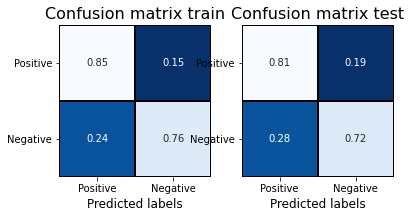

In [21]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)       
plot_confusion_matrix(Y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix train',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(Y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix test',
                      class_names=['Positive', 'Negative'])

In [25]:
confusion_matrix(Y_train,y_train_pred)

array([[29642,  5317],
       [ 8497, 26544]])

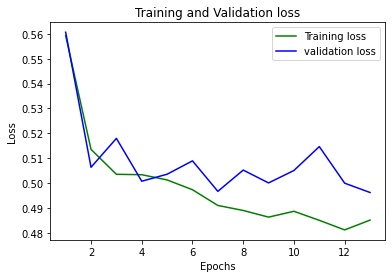

In [23]:
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(1,14)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()      #The below graph shows that the model is a bit overfit :(

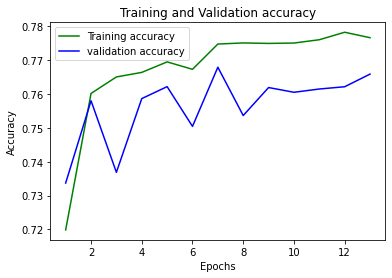

In [24]:
loss_train = hist.history['accuracy']
loss_val = hist.history['val_accuracy']
epochs = range(1,14)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# serialize model to JSON
model_json = model.to_json()
with open("static/model/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/SDL Lab 1 Twitter/model.h5")

NameError: name 'model' is not defined

In [22]:
from keras.models import model_from_json

# load json and create model
json_file = open("static/model/model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("static/model/model.h5")

In [23]:
sent = "This is a bad morning!!!"
sent = clean_data(sent)
tokens = tokenizer1.texts_to_sequences([sent])
tokens = pad_sequences(tokens, maxlen=max_sent_length)
sentiment = loaded_model.predict(np.array(tokens), batch_size=1, verbose = 2)[0][0]
print('Sentiment =', sentiment)
if (round(sentiment) == 0):
    print('Negative')
else:
    print('Positive')

1/1 - 1s
Sentiment = 0.21663979
Negative
